# Create prepared `sensor_data` datasets

1. Sync down `Measurements` folder on google drive
1. Parse different file formats
1. Merge all csv data
1. Output to various file formats, parquet is preferred

## Sync remote data to local

In [1]:
# sync data from google drive (first time takes up to 2 hours ;)
!date
!rclone sync vfa-Measurements:/ ../data/Measurements/

Tue Oct  2 10:03:48 CEST 2018
2018/10/02 10:04:50 NOTICE: byspireMonitoring28_12_1402.csv: Duplicate object found in source - ignoring
2018/10/02 10:04:50 NOTICE: Rack_2_3_05_1559.csv: Duplicate object found in source - ignoring
2018/10/02 10:04:50 NOTICE: Rack_2_4_05_1059.csv: Duplicate object found in source - ignoring
2018/10/02 10:04:50 NOTICE: Rack_3_3_05_1558.csv: Duplicate object found in source - ignoring
2018/10/02 10:04:50 NOTICE: Rack_3_4_05_1057.csv: Duplicate object found in source - ignoring


# Parse the local data

In [1]:
import pandas as pd
import sys
import matplotlib.pyplot as plt

sys.path.append("../shared-libraries/")
pd.set_option('display.max_rows', 10)

In [2]:
files = !ls ../data/Measurements/
se_files = pd.Series(files)
se_files

0                  Rack_0_07_06-2108.csv
1                  Rack_0_07_06-2109.csv
2                  Rack_0_07_09-1431.csv
3                  Rack_0_08_05-1523.csv
4                  Rack_0_08_08-1743.csv
                      ...               
6223    byspireMonitoring_21_03-1243.csv
6224    byspireMonitoring_21_03-1319.csv
6225    byspireMonitoring_22_03-1129.csv
6226    byspireMonitoring_22_03-1143.csv
6227                   prepared-datasets
Length: 6228, dtype: object

In [3]:
# Check the first few characters for different types of files
se_files.str.slice(0,4).value_counts()

Rack    5676
bysp     551
prep       1
dtype: int64

In [4]:
from data_io import parse_sensor_filename
se_files.apply(parse_sensor_filename)

0       {'FILENAME': 'Rack_0_07_06-2108.csv', 'PATTERN...
1       {'FILENAME': 'Rack_0_07_06-2109.csv', 'PATTERN...
2       {'FILENAME': 'Rack_0_07_09-1431.csv', 'PATTERN...
3       {'FILENAME': 'Rack_0_08_05-1523.csv', 'PATTERN...
4       {'FILENAME': 'Rack_0_08_08-1743.csv', 'PATTERN...
                              ...                        
6223    {'FILENAME': 'byspireMonitoring_21_03-1243.csv...
6224    {'FILENAME': 'byspireMonitoring_21_03-1319.csv...
6225    {'FILENAME': 'byspireMonitoring_22_03-1129.csv...
6226    {'FILENAME': 'byspireMonitoring_22_03-1143.csv...
6227                    {'FILENAME': 'prepared-datasets'}
Length: 6228, dtype: object

In [5]:
df_inventory = se_files.apply(parse_sensor_filename).apply(pd.Series)
df_inventory

,FILENAME,FILE_TIMESTAMP,PATTERN_NAME,RACK
0,Rack_0_07_06-2108.csv,2018-06-07 21:08:00,1,0
1,Rack_0_07_06-2109.csv,2018-06-07 21:09:00,1,0
2,Rack_0_07_09-1431.csv,2018-09-07 14:31:00,1,0
3,Rack_0_08_05-1523.csv,2018-05-08 15:23:00,1,0
4,Rack_0_08_08-1743.csv,2018-08-08 17:43:00,1,0
...,...,...,...,...
6223,byspireMonitoring_21_03-1243.csv,2018-03-21 12:43:00,2,None
6224,byspireMonitoring_21_03-1319.csv,2018-03-21 13:19:00,2,None
6225,byspireMonitoring_22_03-1129.csv,2018-03-22 11:29:00,2,None
6226,byspireMonitoring_22_03-1143.csv,2018-03-22 11:43:00,2,None


### Check for missed files

In [6]:
df_inventory['PATTERN_NAME'].value_counts(dropna=False)

1      5675
2       542
3         6
NaN       5
Name: PATTERN_NAME, dtype: int64

In [7]:
df_inventory[df_inventory['PATTERN_NAME'].isnull()]

,FILENAME,FILE_TIMESTAMP,PATTERN_NAME,RACK
16,Rack_1.0_22_03_1259.csv.xlsx,NaT,NaN,NaN
5736,byspireMonitoring16_01_0652.csv.xlsx,NaT,NaN,NaN
5738,byspireMonitoring16_01_0939.csv.xlsx,NaT,NaN,NaN
6203,byspireMonitoring_03_01-1355.xlsx,NaT,NaN,NaN
6227,prepared-datasets,NaT,NaN,NaN


# Load into a uniform
Grab as much metadata as possible along the way

In [8]:
from data_io import sensor_csv_reader

In [9]:
df_sensor_csv_reader = df_inventory[df_inventory.PATTERN_NAME.notnull()]\
    .FILENAME.apply(sensor_csv_reader)
df_sensor_csv_reader

,DF,DF_EXCEPTION,FILENAME,HEADER,NCOLS,NROWS
0,Date Time Air temp Humidity W...,None,Rack_0_07_06-2108.csv,True,10.0,52.0
1,Date Time Air temp Humidity W...,None,Rack_0_07_06-2109.csv,True,10.0,51.0
2,Date Time Air temp Humidity W...,None,Rack_0_07_09-1431.csv,True,10.0,29.0
3,Date Time Air temp Humidity W...,None,Rack_0_08_05-1523.csv,True,10.0,37.0
4,Date Time Air temp Humidity Wa...,None,Rack_0_08_08-1743.csv,True,10.0,2.0
...,...,...,...,...,...,...
6222,Date Time Air temp Humidity Wa...,None,byspireMonitoring_21_03-1124.csv,False,9.0,9.0
6223,Date Time Air temp Humidity W...,None,byspireMonitoring_21_03-1243.csv,False,9.0,14.0
6224,Date Time Air temp Humidity W...,None,byspireMonitoring_21_03-1319.csv,False,9.0,41.0
6225,Date Time Air temp Humidity Wa...,None,byspireMonitoring_22_03-1129.csv,False,9.0,2.0


In [10]:
df_sensor_csv_reader.DF_EXCEPTION.unique()

array([None, 'No columns to parse from file', ''], dtype=object)

In [11]:
df_sensor_data = pd.concat(df_sensor_csv_reader.DF.tolist(), sort=False)
df_sensor_data

,Date,Time,Air temp,Humidity,Water level,Water temp,EC,pH,CO2,DO,FILENAME
0,2018-07-06,21:08:19,28.30,47.70,25.0,24.60,1.80,5.20,670.00,6.8,Rack_0_07_06-2108.csv
1,2018-07-06,21:09:19,28.30,47.80,25.0,24.60,1.80,5.20,570.00,6.2,Rack_0_07_06-2108.csv
2,2018-07-06,21:10:19,28.30,47.80,25.0,24.60,1.80,5.20,568.00,6.3,Rack_0_07_06-2108.csv
3,2018-07-06,21:11:19,28.30,47.70,25.0,24.60,1.80,5.20,519.00,6.9,Rack_0_07_06-2108.csv
4,2018-07-06,21:12:19,28.40,47.50,25.0,24.70,1.80,5.20,473.00,6.2,Rack_0_07_06-2108.csv
...,...,...,...,...,...,...,...,...,...,...,...
4,2018-03-22,11:48:21,26.05,45.76,39.0,23.12,1.79,6.65,3.74,NaN,byspireMonitoring_22_03-1143.csv
5,2018-03-22,11:49:21,26.04,45.90,39.0,23.12,1.79,6.65,3.75,NaN,byspireMonitoring_22_03-1143.csv
6,2018-03-22,11:50:21,26.04,45.94,39.0,23.12,1.71,6.66,3.74,NaN,byspireMonitoring_22_03-1143.csv
7,2018-03-22,11:51:21,26.03,46.01,39.0,23.12,1.75,6.66,3.76,NaN,byspireMonitoring_22_03-1143.csv


# Basic QA of data

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12059de48>,
      dtype=object)

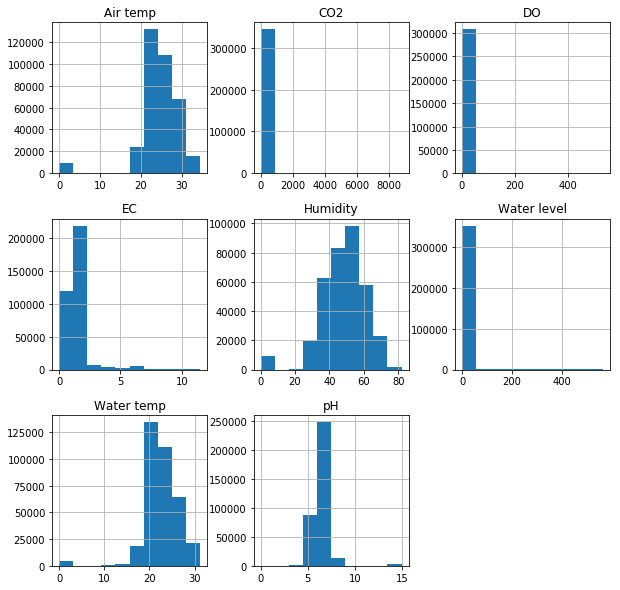

In [12]:
df_sensor_data.hist(figsize=(10,10))

/opt/conda/envs/vfa-01/lib/python3.5/site-packages/numpy/lib/histograms.py:746: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/conda/envs/vfa-01/lib/python3.5/site-packages/numpy/lib/histograms.py:747: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


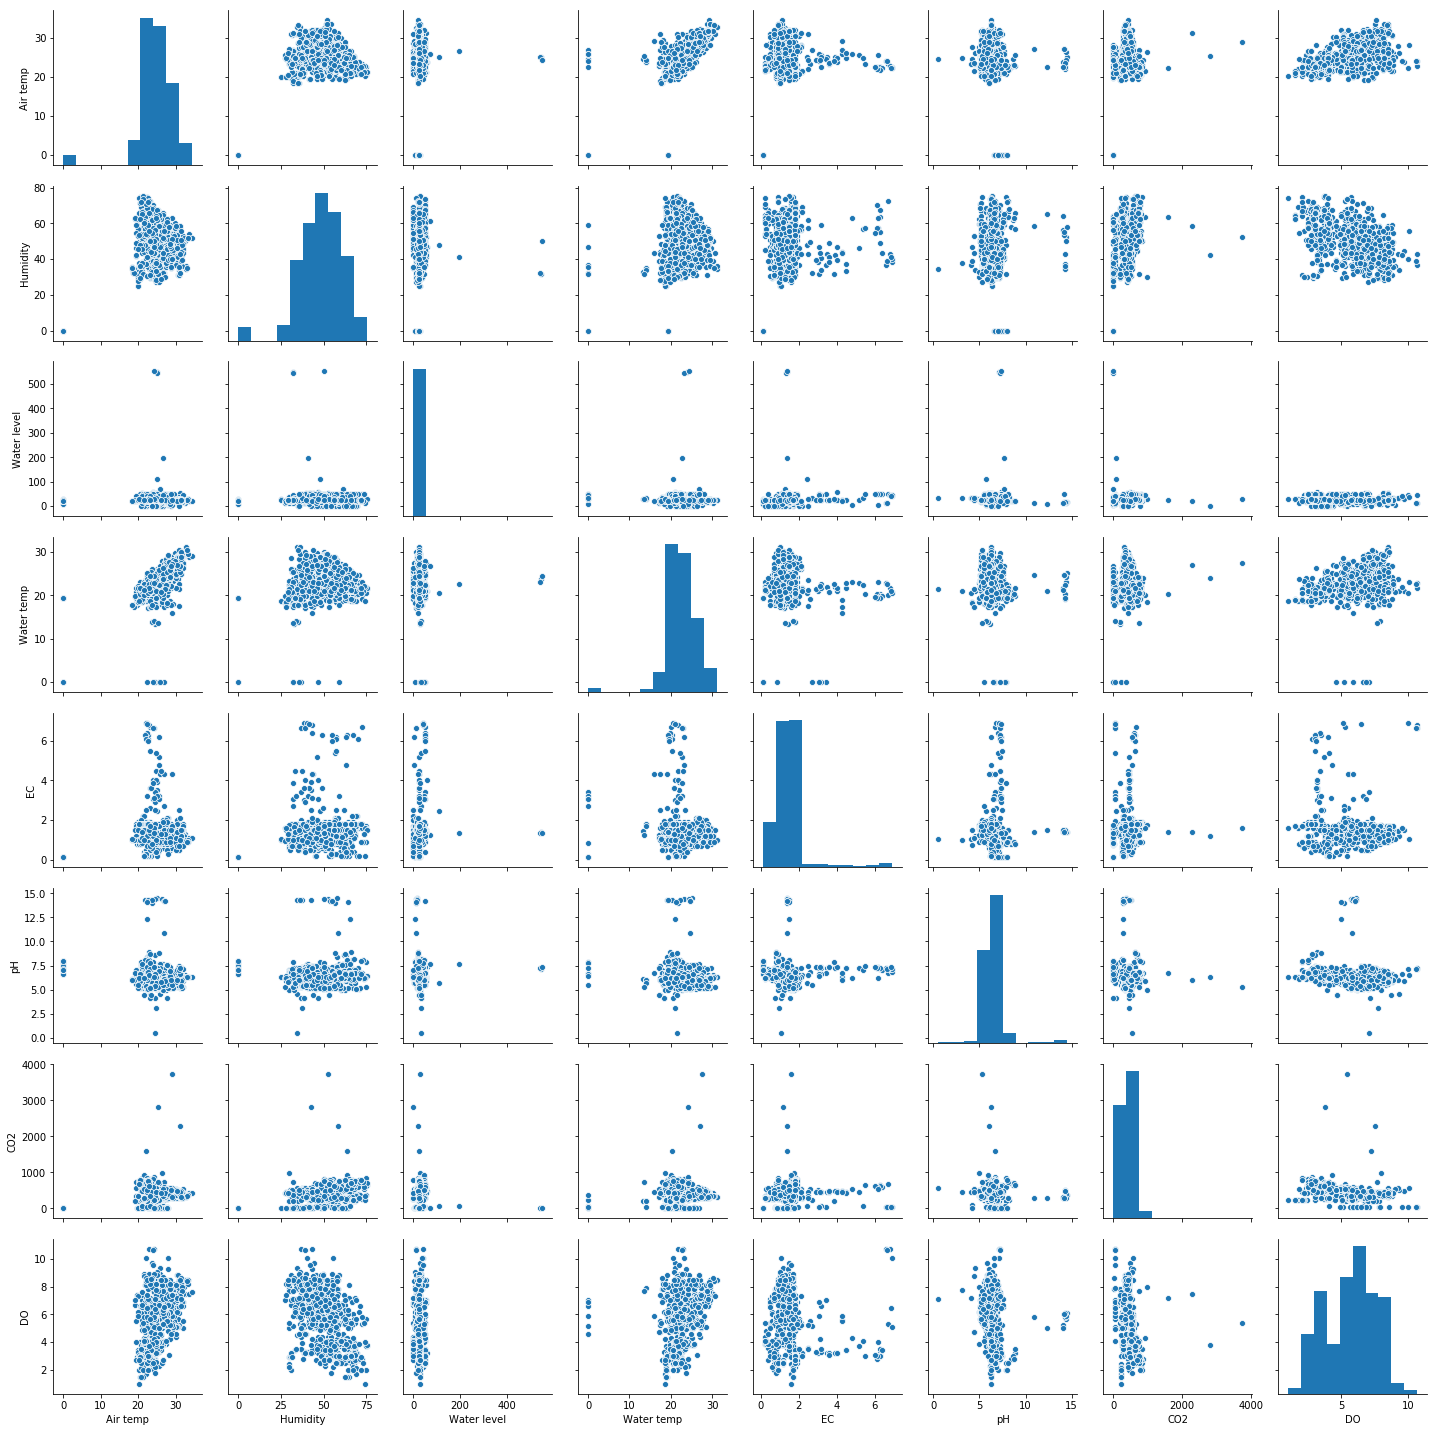

In [13]:
import seaborn as sns
sns.pairplot(df_sensor_data.sample(1000))

# Output dataset

### Fix the timestamps

In [14]:
import datetime
from data_io import sensor_time_parser

In [15]:
df_sensor_data['Time (raw)'] = df_sensor_data['Time']
df_sensor_data['Time'] = df_sensor_data['Time (raw)'].apply(sensor_time_parser)
df_sensor_data

,Date,Time,Air temp,Humidity,Water level,Water temp,EC,pH,CO2,DO,FILENAME,Time (raw)
0,2018-07-06,21:08:19,28.30,47.70,25.0,24.60,1.80,5.20,670.00,6.8,Rack_0_07_06-2108.csv,21:08:19
1,2018-07-06,21:09:19,28.30,47.80,25.0,24.60,1.80,5.20,570.00,6.2,Rack_0_07_06-2108.csv,21:09:19
2,2018-07-06,21:10:19,28.30,47.80,25.0,24.60,1.80,5.20,568.00,6.3,Rack_0_07_06-2108.csv,21:10:19
3,2018-07-06,21:11:19,28.30,47.70,25.0,24.60,1.80,5.20,519.00,6.9,Rack_0_07_06-2108.csv,21:11:19
4,2018-07-06,21:12:19,28.40,47.50,25.0,24.70,1.80,5.20,473.00,6.2,Rack_0_07_06-2108.csv,21:12:19
...,...,...,...,...,...,...,...,...,...,...,...,...
4,2018-03-22,11:48:21,26.05,45.76,39.0,23.12,1.79,6.65,3.74,NaN,byspireMonitoring_22_03-1143.csv,11:48:21
5,2018-03-22,11:49:21,26.04,45.90,39.0,23.12,1.79,6.65,3.75,NaN,byspireMonitoring_22_03-1143.csv,11:49:21
6,2018-03-22,11:50:21,26.04,45.94,39.0,23.12,1.71,6.66,3.74,NaN,byspireMonitoring_22_03-1143.csv,11:50:21
7,2018-03-22,11:51:21,26.03,46.01,39.0,23.12,1.75,6.66,3.76,NaN,byspireMonitoring_22_03-1143.csv,11:51:21


In [16]:
df_sensor_data['DT'] = df_sensor_data[['Date', 'Time']].apply(
    lambda r: datetime.datetime.combine(r['Date'], r['Time']),
    axis=1,
)

df_sensor_data = df_sensor_data.sort_values(by="DT").reset_index(drop=True)
df_sensor_data

,Date,Time,Air temp,Humidity,Water level,Water temp,EC,pH,CO2,DO,FILENAME,Time (raw),DT
0,2017-12-21,16:13:31,20.18,31.92,19.0,17.81,0.99,6.05,NaN,NaN,byspireMonitoring21_12-1613.csv,16:13:31,2017-12-21 16:13:31
1,2017-12-21,16:13:37,19.96,33.67,19.0,17.94,0.95,6.03,NaN,NaN,byspireMonitoring21_12-1613.csv,16:13:37,2017-12-21 16:13:37
2,2017-12-21,16:14:20,19.94,33.52,42.0,17.94,0.99,6.10,NaN,NaN,byspireMonitoring21_12-1613.csv,16:14:20,2017-12-21 16:14:20
3,2017-12-21,16:15:20,19.93,33.37,67.0,17.94,0.99,6.10,NaN,NaN,byspireMonitoring21_12-1613.csv,16:15:20,2017-12-21 16:15:20
4,2017-12-21,16:16:20,19.93,35.50,25.0,17.94,0.99,6.04,NaN,NaN,byspireMonitoring21_12-1613.csv,16:16:20,2017-12-21 16:16:20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
355844,2018-12-08,23:57:56,23.10,49.70,28.0,21.30,1.50,6.40,521.0,5.8,Rack_5_12_08_2259.csv,23:57:56,2018-12-08 23:57:56
355845,2018-12-08,23:58:06,22.00,55.50,26.0,20.20,1.10,6.60,595.0,3.9,Rack_4_12_08_2355.csv,23:58:06,2018-12-08 23:58:06
355846,2018-12-08,23:58:56,23.10,49.80,28.0,21.30,1.50,6.40,528.0,5.9,Rack_5_12_08_2259.csv,23:58:56,2018-12-08 23:58:56
355847,2018-12-08,23:59:06,22.00,55.20,26.0,20.20,1.10,6.60,590.0,4.0,Rack_4_12_08_2355.csv,23:59:06,2018-12-08 23:59:06


### Add in the rack

In [38]:
df_sensor_data_w_rack = pd.merge(df_sensor_data, df_inventory, on="FILENAME", how='left')
df_sensor_data_w_rack

,Date,Time,Air temp,Humidity,Water level,Water temp,EC,pH,CO2,DO,FILENAME,Time (raw),DT,FILE_TIMESTAMP,PATTERN_NAME,RACK
0,2017-12-21,16:13:31,20.18,31.92,19.0,17.81,0.99,6.05,NaN,NaN,byspireMonitoring21_12-1613.csv,16:13:31,2017-12-21 16:13:31,2018-12-21 16:13:00,2,None
1,2017-12-21,16:13:37,19.96,33.67,19.0,17.94,0.95,6.03,NaN,NaN,byspireMonitoring21_12-1613.csv,16:13:37,2017-12-21 16:13:37,2018-12-21 16:13:00,2,None
2,2017-12-21,16:14:20,19.94,33.52,42.0,17.94,0.99,6.10,NaN,NaN,byspireMonitoring21_12-1613.csv,16:14:20,2017-12-21 16:14:20,2018-12-21 16:13:00,2,None
3,2017-12-21,16:15:20,19.93,33.37,67.0,17.94,0.99,6.10,NaN,NaN,byspireMonitoring21_12-1613.csv,16:15:20,2017-12-21 16:15:20,2018-12-21 16:13:00,2,None
4,2017-12-21,16:16:20,19.93,35.50,25.0,17.94,0.99,6.04,NaN,NaN,byspireMonitoring21_12-1613.csv,16:16:20,2017-12-21 16:16:20,2018-12-21 16:13:00,2,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355844,2018-12-08,23:57:56,23.10,49.70,28.0,21.30,1.50,6.40,521.0,5.8,Rack_5_12_08_2259.csv,23:57:56,2018-12-08 23:57:56,2018-08-12 22:59:00,1,5
355845,2018-12-08,23:58:06,22.00,55.50,26.0,20.20,1.10,6.60,595.0,3.9,Rack_4_12_08_2355.csv,23:58:06,2018-12-08 23:58:06,2018-08-12 23:55:00,1,4
355846,2018-12-08,23:58:56,23.10,49.80,28.0,21.30,1.50,6.40,528.0,5.9,Rack_5_12_08_2259.csv,23:58:56,2018-12-08 23:58:56,2018-08-12 22:59:00,1,5
355847,2018-12-08,23:59:06,22.00,55.20,26.0,20.20,1.10,6.60,590.0,4.0,Rack_4_12_08_2355.csv,23:59:06,2018-12-08 23:59:06,2018-08-12 23:55:00,1,4


### Write files
- csv
- hdf
- json

In [39]:
BATCH = str(datetime.datetime.today().date())
BATCH

'2018-10-02'

In [40]:
csv_dir = "../data/Measurements/prepared-datasets/sensor_data_csv/BATCH={BATCH}/".format(BATCH=BATCH)
json_dir = "../data/Measurements/prepared-datasets/sensor_data_json/BATCH={BATCH}/".format(BATCH=BATCH)
parquet_dir = "../data/Measurements/prepared-datasets/sensor_data_parquet/BATCH={BATCH}/".format(BATCH=BATCH)

In [45]:
# write csv
!mkdir -p {csv_dir}
df_sensor_data_w_rack.to_csv(
    csv_dir + "part.csv"
)
#!head -n 3 {csv_dir + "part.csv"}

In [46]:
# write json
!mkdir -p {json_dir}
df_sensor_data_w_rack.to_json(
    json_dir + "part.json", orient='records', lines=True
)
!head -c 512 {json_dir + "part.json"}

{"Date":1513814400000,"Time":"16:13:31","Air temp":20.18,"Humidity":31.92,"Water level":19.0,"Water temp":17.81,"EC":0.99,"pH":6.05,"CO2":null,"DO":null,"FILENAME":"byspireMonitoring21_12-1613.csv","Time (raw)":"16:13:31","DT":1513872811000,"FILE_TIMESTAMP":1545408780000,"PATTERN_NAME":"2","RACK":null}
{"Date":1513814400000,"Time":"16:13:37","Air temp":19.96,"Humidity":33.67,"Water level":19.0,"Water temp":17.94,"EC":0.95,"pH":6.03,"CO2":null,"DO":null,"FILENAME":"byspireMonitoring21_12-1613.csv","Time (raw

In [47]:
# write parquet
# -- this still seems to be the optimal performance, especially since it plays nice with BigTable/Athena
!mkdir -p {parquet_dir}
df_sensor_data_w_rack.to_parquet(parquet_dir + "part.parquet")

# and the partitioned columns for example;
pd.read_parquet("../data/Measurements/prepared-datasets/sensor_data_parquet")

,Date,Time,Air temp,Humidity,Water level,Water temp,EC,pH,CO2,DO,FILENAME,Time (raw),DT,FILE_TIMESTAMP,PATTERN_NAME,RACK,BATCH
0,2017-12-21,16:13:31,20.18,31.92,19.0,17.81,0.99,6.05,NaN,NaN,byspireMonitoring21_12-1613.csv,16:13:31,2017-12-21 16:13:31,2018-12-21 16:13:00,2,None,2018-10-02
1,2017-12-21,16:13:37,19.96,33.67,19.0,17.94,0.95,6.03,NaN,NaN,byspireMonitoring21_12-1613.csv,16:13:37,2017-12-21 16:13:37,2018-12-21 16:13:00,2,None,2018-10-02
2,2017-12-21,16:14:20,19.94,33.52,42.0,17.94,0.99,6.10,NaN,NaN,byspireMonitoring21_12-1613.csv,16:14:20,2017-12-21 16:14:20,2018-12-21 16:13:00,2,None,2018-10-02
3,2017-12-21,16:15:20,19.93,33.37,67.0,17.94,0.99,6.10,NaN,NaN,byspireMonitoring21_12-1613.csv,16:15:20,2017-12-21 16:15:20,2018-12-21 16:13:00,2,None,2018-10-02
4,2017-12-21,16:16:20,19.93,35.50,25.0,17.94,0.99,6.04,NaN,NaN,byspireMonitoring21_12-1613.csv,16:16:20,2017-12-21 16:16:20,2018-12-21 16:13:00,2,None,2018-10-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355844,2018-12-08,23:57:56,23.10,49.70,28.0,21.30,1.50,6.40,521.0,5.8,Rack_5_12_08_2259.csv,23:57:56,2018-12-08 23:57:56,2018-08-12 22:59:00,1,5,2018-10-02
355845,2018-12-08,23:58:06,22.00,55.50,26.0,20.20,1.10,6.60,595.0,3.9,Rack_4_12_08_2355.csv,23:58:06,2018-12-08 23:58:06,2018-08-12 23:55:00,1,4,2018-10-02
355846,2018-12-08,23:58:56,23.10,49.80,28.0,21.30,1.50,6.40,528.0,5.9,Rack_5_12_08_2259.csv,23:58:56,2018-12-08 23:58:56,2018-08-12 22:59:00,1,5,2018-10-02
355847,2018-12-08,23:59:06,22.00,55.20,26.0,20.20,1.10,6.60,590.0,4.0,Rack_4_12_08_2355.csv,23:59:06,2018-12-08 23:59:06,2018-08-12 23:55:00,1,4,2018-10-02


# Save the metadata / inventory


In [50]:
df_complete_inventory = pd.merge(
    df_sensor_csv_reader.drop("DF", axis=1),
    df_inventory,
    on="FILENAME",
)
df_complete_inventory

,DF_EXCEPTION,FILENAME,HEADER,NCOLS,NROWS,FILE_TIMESTAMP,PATTERN_NAME,RACK
0,None,Rack_0_07_06-2108.csv,True,10.0,52.0,2018-06-07 21:08:00,1,0
1,None,Rack_0_07_06-2109.csv,True,10.0,51.0,2018-06-07 21:09:00,1,0
2,None,Rack_0_07_09-1431.csv,True,10.0,29.0,2018-09-07 14:31:00,1,0
3,None,Rack_0_08_05-1523.csv,True,10.0,37.0,2018-05-08 15:23:00,1,0
4,None,Rack_0_08_08-1743.csv,True,10.0,2.0,2018-08-08 17:43:00,1,0
...,...,...,...,...,...,...,...,...
6218,None,byspireMonitoring_21_03-1124.csv,False,9.0,9.0,2018-03-21 11:24:00,2,None
6219,None,byspireMonitoring_21_03-1243.csv,False,9.0,14.0,2018-03-21 12:43:00,2,None
6220,None,byspireMonitoring_21_03-1319.csv,False,9.0,41.0,2018-03-21 13:19:00,2,None
6221,None,byspireMonitoring_22_03-1129.csv,False,9.0,2.0,2018-03-22 11:29:00,2,None


In [51]:
df_complete_inventory.astype(str)\
    .to_excel("../data/Measurements/prepared-datasets/sensor_data_inventory.xlsx", sheet_name=BATCH)

# Sync prepared datasets up

In [52]:
!date
!rclone sync ../data/Measurements/prepared-datasets vfa-Measurements:/prepared-datasets

Tue Oct  2 10:36:49 CEST 2018
